In [1]:
#Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import itertools
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50

In [2]:
tf.random.set_seed(42)
np.random.seed(1337)

In [3]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Unzip folder and define data directory.
data_source = "/content/drive/MyDrive/Covid_Dataset.rar" 
data_output = "/content"
!unrar x -Y "/content/drive/MyDrive/Covid_Dataset.rar" "/content"

Streaming output truncated to the last 5000 lines.
Extracting  /content/Covid_Dataset/train/Normal/Normal_1077.png           50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10770.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10771.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10772.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10773.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10774.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10775.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10776.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10778.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10781.png          50%  OK 
Extracting  /content/Covid_Da

In [5]:
#Define the hyper parameters
data_dir = "/content/Covid_Dataset"
classes = ['COVID', 'Normal']
initial_epochs = 50
initial_LR = 0.001
dropout = 0.2
batch_size = 64
configuration = 'ResNet50_'+str(initial_LR)+'_WD_'+str(dropout)+'_'+str(batch_size)

In [6]:
! mkdir $configuration

In [7]:
#Define the data paths
train_path = data_dir + '//train'
valid_path = data_dir + '//valid'
test_path = data_dir + '//test'

In [8]:
#Define batches and use the preprocessing function of ResNET50
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=train_path, classes=classes, batch_size=batch_size)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=valid_path, classes=classes, batch_size=batch_size)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=test_path, classes=classes, batch_size=batch_size, shuffle=False)

Found 8500 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1252 images belonging to 2 classes.


In [9]:
#Define input shape and use the weights from Imagenet and the network is a ResNT50
INPUT_SHAPE = (224,224,3) 
base_model = tf.keras.applications.ResNet50(input_shape= INPUT_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = True

94781440/94765736 [==============================] - 1s 0us/step


In [10]:
for layer in base_model.layers:
  if('conv1' in layer.name or 'conv2' in layer.name):
    layer.trainable = False
  else:
    continue

In [11]:
#Define the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(2, activation = 'sigmoid'))

In [12]:
#Stop training when a monitored metric has stopped improving
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)

#Callback to save the Keras model or model weights at some frequency.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('/content/'+configuration+'/'+configuration+'.h5', monitor='val_loss', save_best_only=True, mode='min')

#Configures the model for training
model.compile(optimizer=Adam(learning_rate=initial_LR, decay=initial_LR / initial_epochs), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,311,874
Non-trainable params: 279,936
_________________________________________________________________


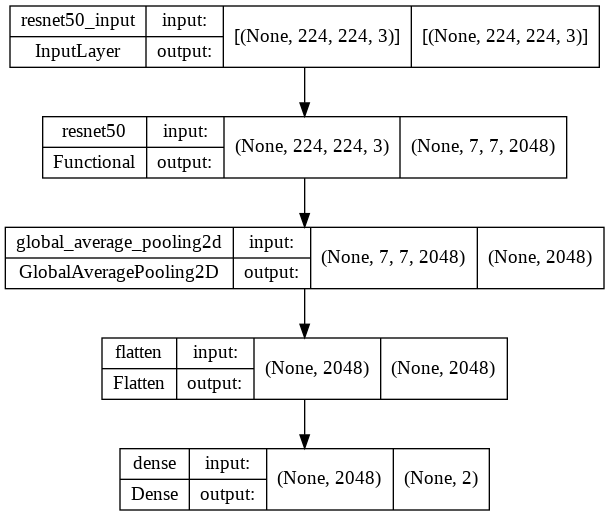

In [14]:
#Plot the model
tf.keras.utils.plot_model(model, to_file= '/content/'+configuration+'/'+configuration+'_MODEL.png', show_shapes=True, show_layer_names=True)

In [15]:
#Trains the model for a fixed number of epochs (iterations on a dataset).
history = model.fit(
      train_batches,
      epochs = initial_epochs,
      validation_data=valid_batches,
      verbose=1,
      callbacks = [earlystopping_callback,checkpoint_callback]
    )

Epoch 1/50
133/133 [==============================] - 60s 340ms/step - loss: 0.1625 - accuracy: 0.9448 - val_loss: 3.7134 - val_accuracy: 0.6450
Epoch 2/50
133/133 [==============================] - 44s 328ms/step - loss: 0.0605 - accuracy: 0.9784 - val_loss: 0.1857 - val_accuracy: 0.9375
Epoch 3/50
133/133 [==============================] - 43s 321ms/step - loss: 0.0398 - accuracy: 0.9855 - val_loss: 1.4462 - val_accuracy: 0.7650
Epoch 4/50
133/133 [==============================] - 44s 327ms/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.4017 - val_accuracy: 0.9175
Epoch 5/50
133/133 [==============================] - 42s 318ms/step - loss: 0.0243 - accuracy: 0.9909 - val_loss: 2.2661 - val_accuracy: 0.6450
Epoch 6/50
133/133 [==============================] - 43s 326ms/step - loss: 0.0241 - accuracy: 0.9922 - val_loss: 0.0440 - val_accuracy: 0.9825
Epoch 7/50
133/133 [==============================] - 44s 331ms/step - loss: 0.0239 - accuracy: 0.9916 - val_loss: 0.0297 - val_ac

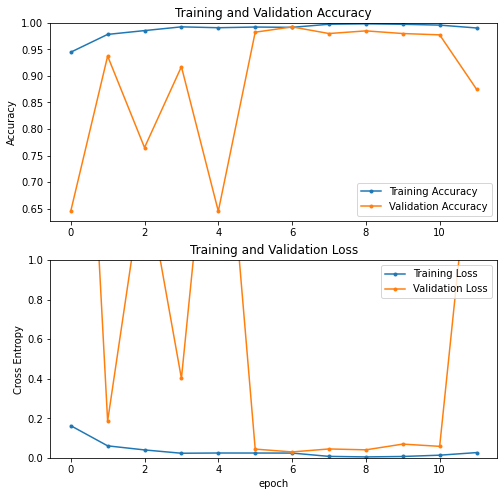

In [16]:
# Plot (training and validation) accuracy and loss figures respectively
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker = '.')
plt.plot(val_acc, label='Validation Accuracy', marker = '.')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker = '.')
plt.plot(val_loss, label='Validation Loss', marker = '.')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/content/'+configuration+'/'+configuration+'_CURVE.png')
plt.show()

In [17]:
ran_epochs = len(history.history['accuracy'])
best_epoch = 0
if(ran_epochs != 50):
  if(ran_epochs > 5):
    best_epoch = ran_epochs - 6  
  else:
    best_epoch = 0
else:
  best_epoch = 49

In [18]:
train_accuracy = history.history['accuracy'][best_epoch]
train_loss = history.history['loss'][best_epoch]
train_accuracy = round(train_accuracy * 100,2)
train_loss = round(train_loss,2)
print(f'Training Accuracy: {train_accuracy}%')
print(f'Training Loss: {train_loss}')

Training Accuracy: 99.16%
Training Loss: 0.02


In [19]:
valid_accuracy = history.history['val_accuracy'][best_epoch]
valid_loss = history.history['val_loss'][best_epoch]
valid_accuracy = round(valid_accuracy * 100,2)
valid_loss = round(valid_loss,2)
print(f'Validation Accuracy: {valid_accuracy}%')
print(f'Validation Loss: {valid_loss}')

Validation Accuracy: 99.25%
Validation Loss: 0.03


In [20]:
#Returns the loss value & metrics values for the model in test mode.
test_loss, test_accuracy = model.evaluate(test_batches)
test_accuracy = round(test_accuracy * 100,2)
test_loss = round(test_loss,2)
print(f'Testing Accuracy: {test_accuracy}%')
print(f'Testing Loss: {test_loss}')

20/20 [==============================] - 4s 201ms/step - loss: 0.0907 - accuracy: 0.9840
Testing Accuracy: 98.4%
Testing Loss: 0.09


In [21]:
#Print the results in a dataframe 
results = {'Training Accuracy': train_accuracy, 'Training Loss':train_loss,
           'Validation Accuracy':valid_accuracy,'Validation Loss':valid_loss,
           'Testing Accuracy':test_accuracy,'Testing Loss':test_loss}
results_df = pd.DataFrame(results, index = [configuration])
results_df = results_df.round(2)
results_df.to_csv('/content/'+configuration+'/'+configuration+'_RESULTS.csv')
results_df

,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Testing Accuracy,Testing Loss
ResNet50_0.001_WD_0.2_64,99.16,0.02,99.25,0.03,98.4,0.09


In [22]:
#Generates output predictions for the input samples.
predictions = model.predict(x=test_batches, verbose = 1)

20/20 [==============================] - 5s 183ms/step


In [23]:
#Print a classification report
from sklearn.metrics import classification_report, confusion_matrix
cr = classification_report(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1), target_names=classes, output_dict=True)
df = pd.DataFrame(cr).transpose()
df = df.round(2)
df.to_csv('/content/'+configuration+'/'+configuration+'_CR.csv')
print(df)

              precision  recall  f1-score  support
COVID              0.99    0.98      0.98   626.00
Normal             0.98    0.99      0.98   626.00
accuracy           0.98    0.98      0.98     0.98
macro avg          0.98    0.98      0.98  1252.00
weighted avg       0.98    0.98      0.98  1252.00


In [24]:
#Define a function to use in plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/'+configuration+'/'+configuration+'_CM.png')

Confusion matrix, without normalization


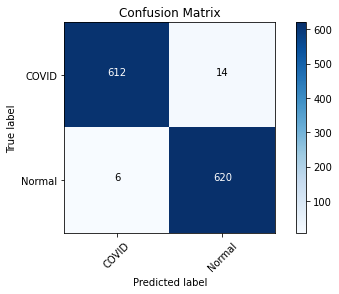

In [25]:
#Plot the confusion matrix 
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')

In [26]:
! cp -r "/content/"$configuration "/content/drive/MyDrive/Big Data Management/Project/Networks"